## CutMix/Mixup 비교실험

### Comparison overview

1. No Augmentation
2. 기본 Augmentation (affine transformation only)
3. No + Mixup 적용
4. No + CutMix 적용
5. Label smoothing

### Todo

1. 훈련 과정의 히스토리를 그래프로 시각화
2. 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능 비교
3. Augmentation 방법들의 영향도에 대해 분석

### Import necessary libs

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import warnings

warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load datasets

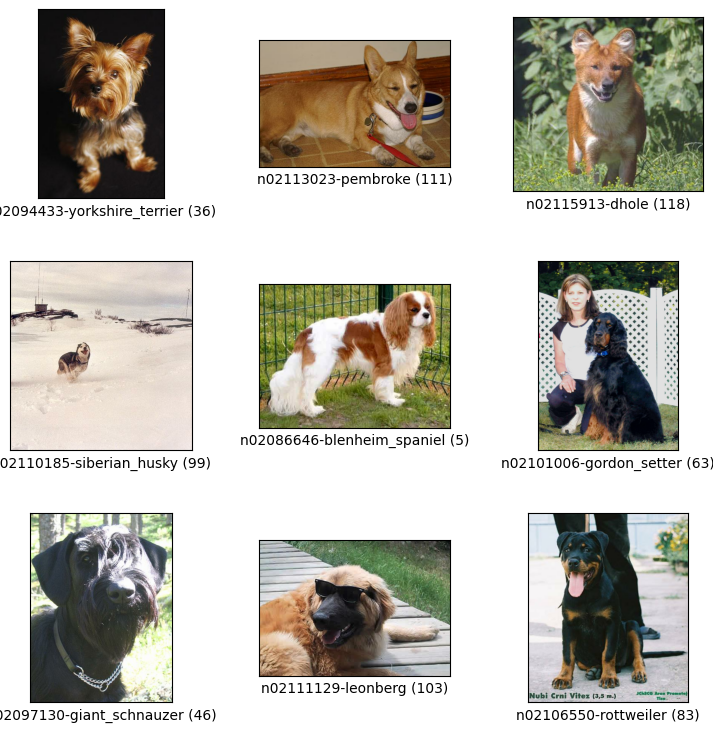

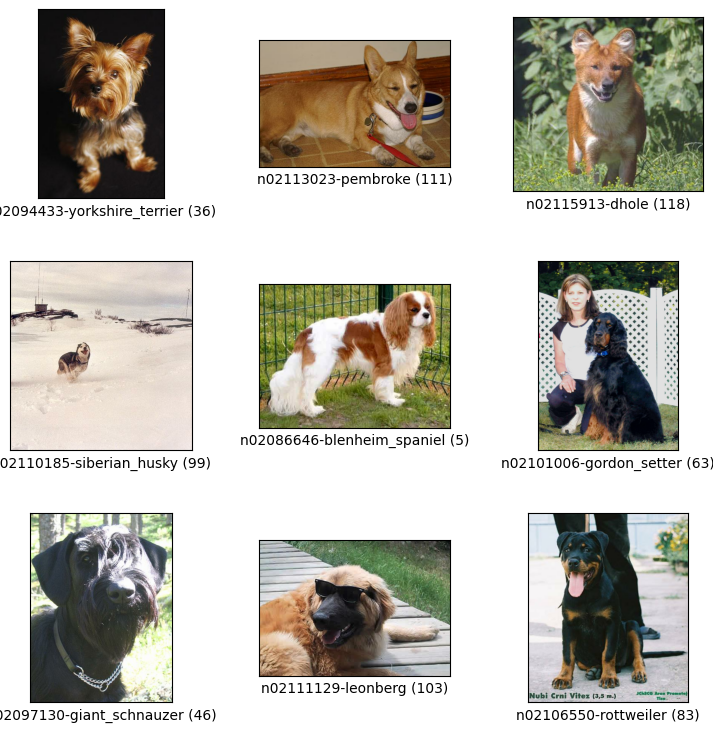

In [4]:
(ds_train, dss_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
tfds.show_examples(ds_train, ds_info)

### Implement preprocess methods

In [5]:
# 이미지 merge 위치 지정
def get_clip_box(image_a):
    image_size_x, image_size_y = image_a.shape[1], image_a.shape[0]
    x = tf.random.uniform([], 0, image_size_x, dtype=tf.int32)
    y = tf.random.uniform([], 0, image_size_y, dtype=tf.int32)
    width = tf.cast(image_size_x * tf.sqrt(1 - tf.random.uniform([])), tf.int32)
    height = tf.cast(image_size_y * tf.sqrt(1 - tf.random.uniform([])), tf.int32)
    x_min = tf.maximum(0, x - width // 2)
    y_min = tf.maximum(0, y - height // 2)
    x_max = tf.minimum(image_size_x, x + width // 2)
    y_max = tf.minimum(image_size_y, y + height // 2)
    return x_min, y_min, x_max, y_max

# 이미지 병합
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    middle = tf.concat([image_a[y_min:y_max, 0:x_min, :], image_b[y_min:y_max, x_min:x_max, :], image_a[y_min:y_max, x_max:, :]], axis=1)
    return tf.concat([image_a[:y_min, :, :], middle, image_a[y_max:, :, :]], axis=0)

# 레이블 병합
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max):
    area_box = (x_max - x_min) * (y_max - y_min)
    total_area = tf.reduce_prod(tf.shape(label_a)[0:2])
    ratio = tf.cast(area_box / total_area, tf.float32)
    return (1 - ratio) * label_a + ratio * label_b

# cutmix 구현
def cutmix(image, label, batch_size=16):
    mixed_imgs, mixed_labels = [], []
    for i in range(batch_size):
        image_a, label_a = image[i], label[i]
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b, label_b = image[j], label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))
    return tf.stack(mixed_imgs), tf.stack(mixed_labels)

In [6]:
# 이미지 병합
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_image, mixed_label

# mixup 구현
def mixup(image, label, batch_size=16):
    mixed_imgs, mixed_labels = [], []
    for i in range(batch_size):
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        mixed_img, mixed_label = mixup_2_images(image[i], image[j], label[i], label[j])
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    return tf.stack(mixed_imgs), tf.stack(mixed_labels)

In [30]:
num_classes = ds_info.features["label"].num_classes

# 이미지 사이즈 조정
def image_norm(i, l):
    return tf.cast(tf.image.resize(i, [224, 224]), tf.float32) / 255.0, l

# 이미지 affine transformation 수행
def image_aug(i, l):
    transforms = tf.constant([
        [1.5, 0, -20, 0, 1.5, -16, 0, 0],       # zoom
        [1, 0, -20, 0, 1, -16, 0, 0],           # translation upper left
        [1, 0, 50, 0, 1, 30, 0, 0],             # translation bottom right
        [1.0, 0.5, -20, 0.5, 1.0, -16, 0, 0],   # shear
        [0.866, 0.5, 0, -0.5, 0.866, 0, 0, 0],  # rotation
        [0.6667, 0, 20, 0, 0.6667, 16, 0, 0],   # opposite of zoom
        [1, 0, 20, 0, 1, 16, 0, 0],             # opposite of translation upper left
        [1, 0, -50, 0, 1, -30, 0, 0],           # opposite of translation bottom right
        [1.0, -0.5, 20, -0.5, 1.0, 16, 0, 0],   # opposite of shear
        [0.866, -0.5, 0, 0.5, 0.866, 0, 0, 0],  # opposite of rotation
    ])
    transform = transforms[tf.random.uniform([], 0, len(transforms), dtype=tf.int32)]
    i = tf.image.random_flip_left_right(i)
    i = tfa.image.transform(i, transform)
    return tf.clip_by_value(i, 0, 1), l

# one hot encoding 수행
def one_hot(i, l):
    l = tf.one_hot(l, num_classes)
    return i, l

# 라벨 스무딩 구현
def label_smoothing(i, l, num_classes=num_classes, factor=0.1):
    l = l * (1 - factor) + (factor / num_classes)
    return i, l

# input choices에 따라 preprocess 수행
def apply_preprocess(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, with_smooth=False):
    ds = ds.map(image_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(one_hot, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if not is_test:
        if with_aug:
            ds = ds.map(image_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.shuffle(buffer_size=200).repeat().batch(batch_size)
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        elif with_smooth:
            ds = ds.map(label_smoothing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [31]:
# 데이터 셋 생성
ds_test = apply_preprocess(dss_test, is_test=True)
ds_train_no_aug = apply_preprocess(ds_train)
ds_train_aug = apply_preprocess(ds_train, with_aug=True)
ds_train_mixup = apply_preprocess(ds_train, with_mixup=True)
ds_train_cutmix = apply_preprocess(ds_train, with_cutmix=True)
ds_train_smooth = apply_preprocess(ds_train, with_smooth=True)

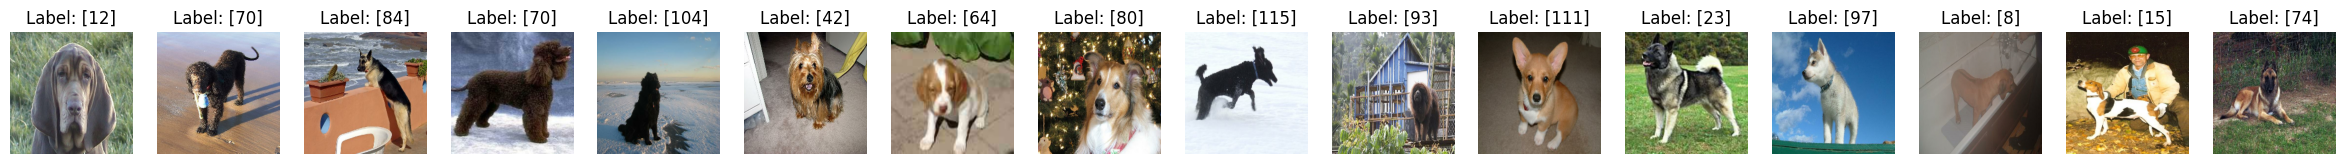

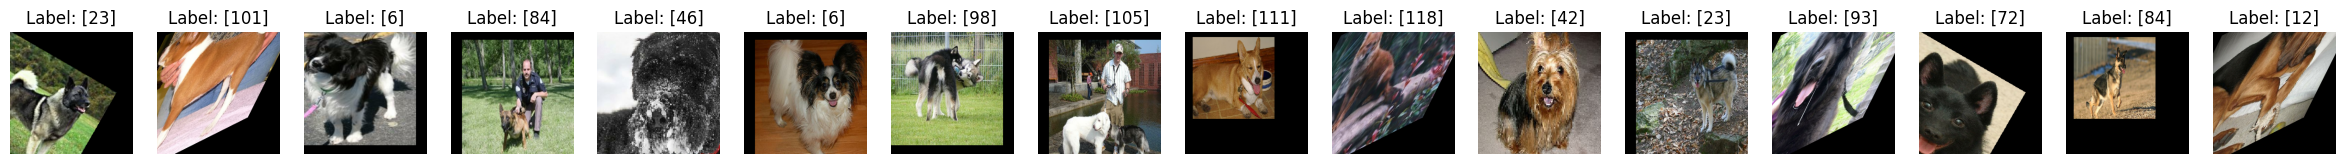

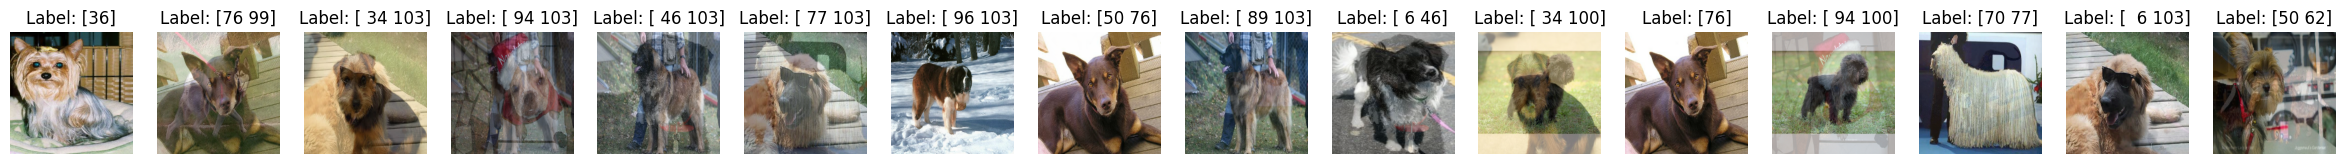

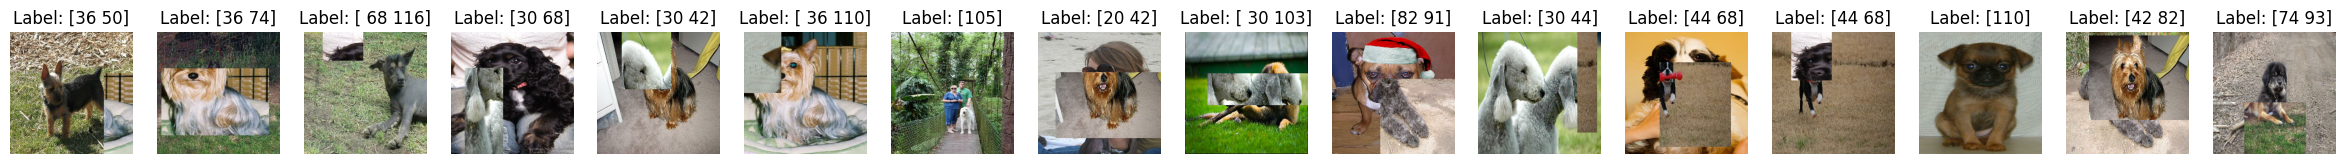

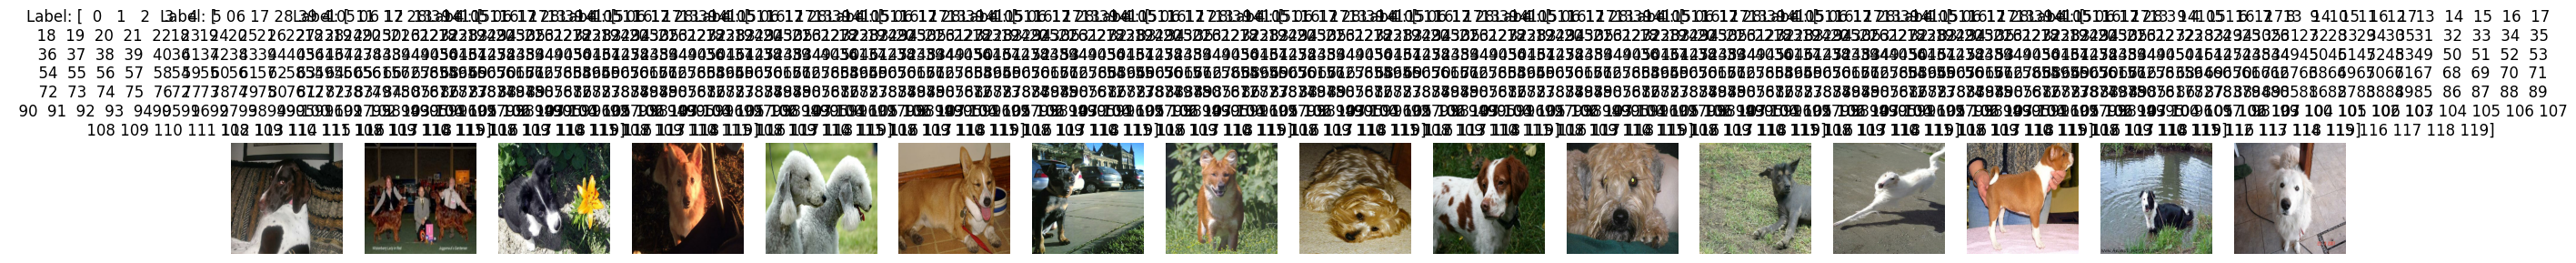

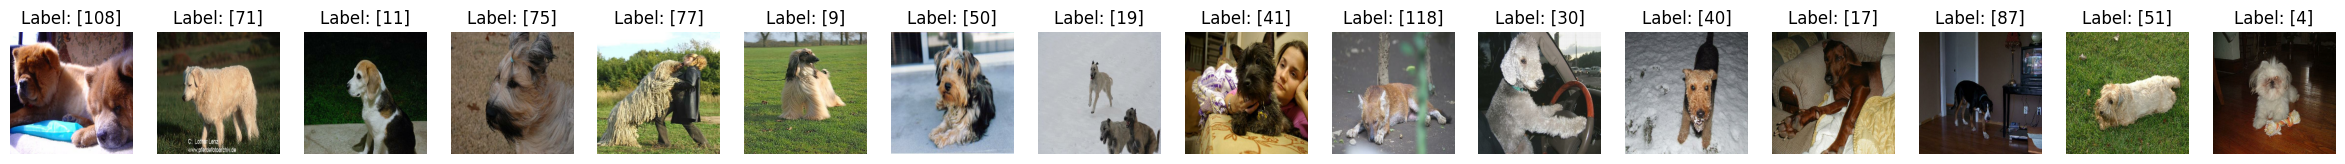

In [32]:
# 순서대로 no aug, aug, mixup, cutmix, label smoothing, test 데이터 셋 display
for dss in [ds_train_no_aug, ds_train_aug, ds_train_mixup, ds_train_cutmix, ds_train_smooth, ds_test]:
    for images, labels in dss.take(1):
        fig, axs = plt.subplots(1, 16, figsize=(30, 4))
        for i in range(16):
            axs[i].imshow(images[i].numpy())
            axs[i].set_title(f"Label: {np.where(labels[i].numpy() != 0)[0]}")
            axs[i].axis("off")
        plt.show()

### Model

In [9]:
EPOCH = 20

model1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

hist_model1 = model1.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


2024-10-14 16:51:36.047136: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-14 16:51:39.517286: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5ef5f80370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-14 16:51:39.517322: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
I0000 00:00:1728892299.590989   92783 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 145s 168ms/step - loss: 2.2271 - accuracy: 0.4372 - val_loss: 3.3486 - val_accuracy: 0.2165
Epoch 2/20
750/750 [==============================] - 125s 167ms/step - loss: 0.7840 - accuracy: 0.7809 - val_loss: 1.1343 - val_accuracy: 0.6656
Epoch 3/20
750/750 [==============================] - 126s 168ms/step - loss: 0.3026 - accuracy: 0.9297 - val_loss: 0.9589 - val_accuracy: 0.7175
Epoch 4/20
750/750 [==============================] - 123s 165ms/step - loss: 0.0741 - accuracy: 0.9923 - val_loss: 1.0051 - val_accuracy: 0.7219
Epoch 5/20
750/750 [==============================] - 124s 166ms/step - loss: 0.0413 - accuracy: 0.9974 - val_loss: 0.9038 - val_accuracy: 0.7432
Epoch 6/20
750/750 [==============================] - 125s 166ms/step - loss: 0.0170 - accuracy: 0.9992 - val_loss: 0.8980 - val_accuracy: 0.7465
Epoch 7/20
750/750 [==============================] - 125s 167ms/step - loss: 0.0126 - accuracy: 0.9997 - val_loss: 0.9128 - val_accura

In [ ]:
model2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

hist_model2 = model2.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [11]:
model3 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

hist_model3 = model3.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 129s 157ms/step - loss: 3.6854 - accuracy: 0.2492 - val_loss: 3.9978 - val_accuracy: 0.1313
Epoch 2/20
750/750 [==============================] - 118s 157ms/step - loss: 2.8471 - accuracy: 0.4822 - val_loss: 1.5014 - val_accuracy: 0.5898
Epoch 3/20
750/750 [==============================] - 118s 157ms/step - loss: 2.5550 - accuracy: 0.5929 - val_loss: 1.2633 - val_accuracy: 0.6454
Epoch 4/20
750/750 [==============================] - 118s 157ms/step - loss: 2.3902 - accuracy: 0.6627 - val_loss: 1.2184 - val_accuracy: 0.6616
Epoch 5/20
750/750 [==============================] - 118s 157ms/step - loss: 2.2627 - accuracy: 0.7063 - val_loss: 1.4250 - val_accuracy: 0.6063
Epoch 6/20
750/750 [==============================] - 118s 157ms/step - loss: 2.1560 - accuracy: 0.7475 - val_loss: 1.3272 - val_accuracy: 0.6411
Epoch 7/20
750/750 [==============================] - 118s 158ms/step - loss: 2.0803 - accuracy: 0.7770 - val_loss: 1.2196 -

In [12]:
model4 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

hist_model4 = model4.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 128s 156ms/step - loss: 3.8252 - accuracy: 0.2117 - val_loss: 3.4263 - val_accuracy: 0.1964
Epoch 2/20
750/750 [==============================] - 117s 156ms/step - loss: 2.9153 - accuracy: 0.4408 - val_loss: 1.3121 - val_accuracy: 0.6342
Epoch 3/20
750/750 [==============================] - 117s 156ms/step - loss: 2.6418 - accuracy: 0.5293 - val_loss: 1.3329 - val_accuracy: 0.6384
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 2.4184 - accuracy: 0.6041 - val_loss: 1.2247 - val_accuracy: 0.6580
Epoch 5/20
750/750 [==============================] - 117s 156ms/step - loss: 2.2254 - accuracy: 0.6693 - val_loss: 1.1731 - val_accuracy: 0.6748
Epoch 6/20
750/750 [==============================] - 117s 156ms/step - loss: 2.1240 - accuracy: 0.7046 - val_loss: 1.2042 - val_accuracy: 0.6831
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 2.0199 - accuracy: 0.7319 - val_loss: 1.2596 -

2024-10-14 19:14:52.964843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7824164 bytes after encountering the first element of size 7824164 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.7987 - accuracy: 0.7948 - val_loss: 1.3584 - val_accuracy: 0.6616
Epoch 12/20
551/750 [=====================>........] - ETA: 25s - loss: 1.7850 - accuracy: 0.7963

2024-10-14 19:16:50.067764: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7824164 bytes after encountering the first element of size 7824164 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.7770 - accuracy: 0.7965 - val_loss: 1.4572 - val_accuracy: 0.6385
Epoch 13/20
750/750 [==============================] - 117s 156ms/step - loss: 1.6987 - accuracy: 0.8116 - val_loss: 1.2497 - val_accuracy: 0.6938
Epoch 14/20
750/750 [==============================] - 117s 156ms/step - loss: 1.6804 - accuracy: 0.8195 - val_loss: 1.4707 - val_accuracy: 0.6404
Epoch 15/20
750/750 [==============================] - 117s 156ms/step - loss: 1.6411 - accuracy: 0.8217 - val_loss: 1.2752 - val_accuracy: 0.6902
Epoch 16/20
551/750 [=====================>........] - ETA: 25s - loss: 1.6270 - accuracy: 0.8326

2024-10-14 19:24:37.997301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 721508 bytes after encountering the first element of size 721508 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.6197 - accuracy: 0.8350 - val_loss: 1.3646 - val_accuracy: 0.6793
Epoch 17/20
551/750 [=====================>........] - ETA: 25s - loss: 1.5996 - accuracy: 0.8320

2024-10-14 19:26:35.014482: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 721508 bytes after encountering the first element of size 721508 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.5977 - accuracy: 0.8322 - val_loss: 1.3836 - val_accuracy: 0.6687
Epoch 18/20
551/750 [=====================>........] - ETA: 25s - loss: 1.6166 - accuracy: 0.8269

2024-10-14 19:28:32.018628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 499508 bytes after encountering the first element of size 499508 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.6159 - accuracy: 0.8280 - val_loss: 1.5209 - val_accuracy: 0.6360
Epoch 19/20
551/750 [=====================>........] - ETA: 25s - loss: 1.5661 - accuracy: 0.8378

2024-10-14 19:30:28.964395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7824164 bytes after encountering the first element of size 7824164 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.5573 - accuracy: 0.8393 - val_loss: 1.5633 - val_accuracy: 0.6398
Epoch 20/20
551/750 [=====================>........] - ETA: 25s - loss: 1.5450 - accuracy: 0.8358

2024-10-14 19:32:25.883862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 721508 bytes after encountering the first element of size 721508 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


750/750 [==============================] - 117s 156ms/step - loss: 1.5395 - accuracy: 0.8374 - val_loss: 1.3452 - val_accuracy: 0.6899


In [ ]:
model5 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

hist_model5 = model5.fit(
    ds_train_smooth,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=40,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 128s 157ms/step - loss: 2.7539 - accuracy: 0.4306 - val_loss: 2.9621 - val_accuracy: 0.2816
Epoch 2/40
750/750 [==============================] - 119s 159ms/step - loss: 1.5700 - accuracy: 0.7887 - val_loss: 1.2118 - val_accuracy: 0.6636
Epoch 3/40
750/750 [==============================] - 121s 162ms/step - loss: 1.1975 - accuracy: 0.9319 - val_loss: 1.0516 - val_accuracy: 0.7128
Epoch 4/40
750/750 [==============================] - 121s 162ms/step - loss: 1.0385 - accuracy: 0.9827 - val_loss: 1.0906 - val_accuracy: 0.7157
Epoch 5/40
750/750 [==============================] - 121s 161ms/step - loss: 0.9682 - accuracy: 0.9942 - val_loss: 1.1353 - val_accuracy: 0.7123
Epoch 6/40
750/750 [==============================] - 122s 163ms/step - loss: 0.9344 - accuracy: 0.9968 - val_loss: 1.1720 - val_accuracy: 0.7102
Epoch 7/40
750/750 [==============================] - 122s 163ms/step - loss: 0.9146 - accuracy: 0.9973 - val_loss: 1.2086 -

In [ ]:
# 모델 세이빙
def save_model(model, model_name):
    model.save(model_name)

def save_history(history, model_name):
    df = pd.DataFrame(history.history)
    with open(f'{model_name}.json', mode='w') as f:
        df.to_json(f)

models = [model1, model2, model3, model4, model5]
histories = [hist_model1, hist_model2, hist_model3, hist_model4, hist_model5]
model_names = ['model1', 'model2', 'model3', 'model4', 'model5']

for model, history, name in zip(models, histories, model_names):
    save_model(model, name)
    save_history(history, name)

### Comparison

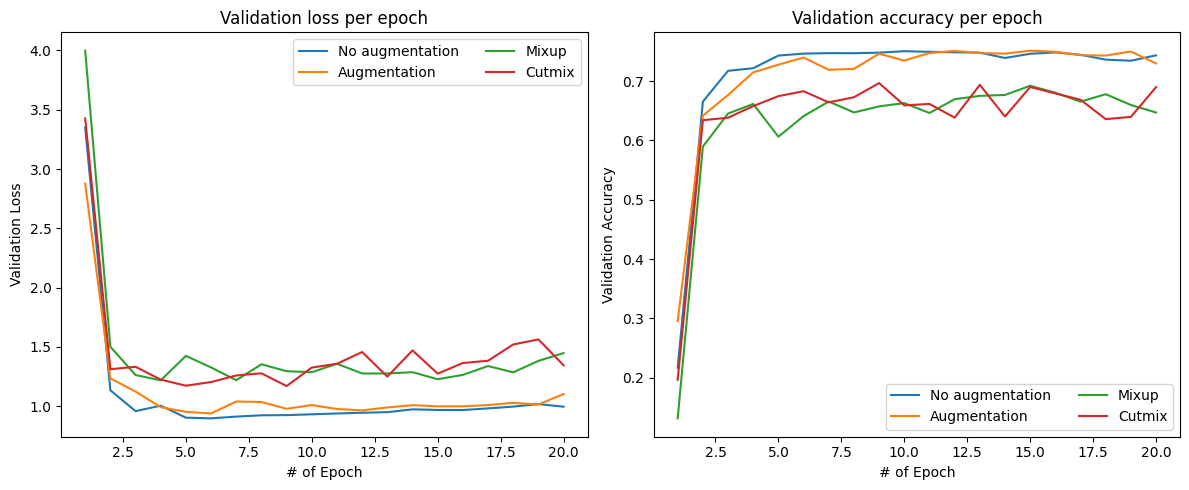

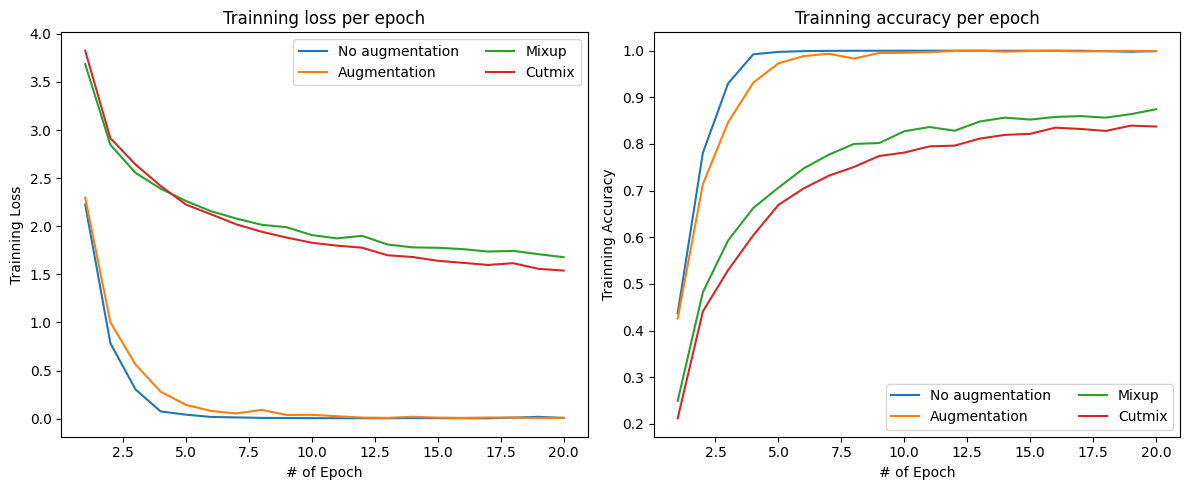

In [35]:
# 모델 train, validation 데이터 plotting
def plot_training_history(histories, labels, EPOCH=EPOCH):
    EPOCHS = range(1, EPOCH + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(EPOCHS, hist['val_loss'], label=label)
    plt.title('Validation loss per epoch')
    plt.xlabel('# of Epoch')
    plt.ylabel('Validation Loss')
    plt.legend(loc='upper right', ncol=2)
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(EPOCHS, hist['val_accuracy'], label=label)
    plt.title('Validation accuracy per epoch')
    plt.xlabel('# of Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='lower right', ncol=2)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(EPOCHS, hist['loss'], label=label)
    plt.title('Training loss per epoch')
    plt.xlabel('# of Epoch')
    plt.ylabel('Training Loss')
    plt.legend(loc='upper right', ncol=2)
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(EPOCHS, hist['accuracy'], label=label)
    plt.title('Training accuracy per epoch')
    plt.xlabel('# of Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(loc='lower right', ncol=2)
    plt.tight_layout()
    plt.show()

# 데이터 불러오기
histories = []
for name in model_names:
    df = pd.read_json(f'{name}.json')
    histories.append(df.to_dict(orient='list'))
plot_training_history(histories, ['No augmentation', 'Augmentation', 'Mixup', 'Cutmix', 'Label Smoothing'])

### Conclusion

#### 성능 비교:

| Augmentation Method | Converging Epoch | Min Val Loss | Max Val Accuracy |
| --- | --- | --- | --- |
| No Augmentation | 5 | 0.8980 | 0.7506 |
| Default Augmentation | 10 | N/A | N/A |
| MixUp | N/A | 1.2184 | 0.6923 |
| CutMix | N/A | 1.1703 | 0.6968 |
| Label Smoothing | N/A | N/A | N/A |

Augmentation이 있고, MixUp이나 CutMix를 사용하면 더욱 더 과적합이 느리게 왔다.
하지만 학습 후 일정 accuracy에 도달하는 속도가 느려졌다.

#### 실험:

N/A

#### 느낀 점:

생각보다 학습이 느리게 진행되서 (epochs: 40) 빨리 시작할걸 생각이 들었다. 다른 모듈보다 데이터 증강이 조금 더 직관적이어서 좋았다. (결과 해석 부분은 조금 더 난해했다.)